In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.utils.class_weight import compute_class_weight


2025-09-19 11:48:50.002908: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  3


2025-09-19 11:48:56.579775: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-09-19 11:49:00.049462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-09-19 11:49:00.051404: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-09-19 11:49:00.052450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2025-09

In [3]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

2025-09-19 11:49:00.120662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3 Physical GPUs, 3 Logical GPUs


2025-09-19 11:49:00.392734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-09-19 11:49:00.394132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2025-09-19 11:49:00.394946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2025-09-19 11:49:00.401318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1, 2
2025-09-19 11:49:00.401378:

In [4]:
#Reading files into a log
import sys
import logging

nblog = open("nb_id.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [5]:
np.random.seed(42)
tf.random.set_seed(8)


In [30]:
def build_model(p_i):
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "track")
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "tower")
    y = keras.layers.BatchNormalization()(input_1)
    z = keras.layers.BatchNormalization()(input_2)
    cnn_1 = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
    cnn_2 = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
    dnn = keras.Sequential([
          keras.layers.Dense(64, activation = 'relu'),
          keras.layers.Dense(64, activation = 'relu'),
          keras.layers.Dense(3, activation = 'softmax')
    ])

    x_1 = cnn_1(y)
    x_2 = cnn_2(z)
    x_3 = keras.layers.Concatenate()([x_1, x_2])
    x_out = dnn(x_3)
    model = keras.Model(         
    inputs=[input_1, input_2],
    outputs=x_out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [31]:
def build_model_clustering(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [32]:
#Preparing samples
n_samples = 3
os.chdir('/home/manhducnmd/manhducnmd/Delphes-3.5.0')    
sample_1_1_train_track = np.load(f'drellyan_region_1_track.npy')
sample_1_1_train_tower = np.load(f'drellyan_region_1_tower.npy')
true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                          np.shape(sample_1_1_train_track)[0]).reshape(np.shape(sample_1_1_train_track)[0],n_samples)

sample_1_2_train_track = np.load(f'ww_region_1_track.npy')
sample_1_2_train_tower = np.load(f'ww_region_1_tower.npy')
true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                          np.shape(sample_1_2_train_track)[0]).reshape(np.shape(sample_1_2_train_track)[0],n_samples)

sample_1_3_train_track = np.load(f'ttbar_region_1_track.npy')
sample_1_3_train_tower = np.load(f'ttbar_region_1_tower.npy')
true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_1_3_train_track)[0]).reshape(np.shape(sample_1_3_train_track)[0],n_samples)

sample_2_1_train_track = np.load(f'drellyan_region_2_track.npy')
sample_2_1_train_tower = np.load(f'drellyan_region_2_tower.npy')
true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                        np.shape(sample_2_1_train_track)[0]).reshape(np.shape(sample_2_1_train_track)[0],n_samples)


sample_2_2_train_track = np.load(f'ww_region_2_track.npy')
sample_2_2_train_tower = np.load(f'ww_region_2_tower.npy')
true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                        np.shape(sample_2_2_train_track)[0]).reshape(np.shape(sample_2_2_train_track)[0],n_samples)


sample_2_3_train_track = np.load(f'ttbar_region_2_track.npy')
sample_2_3_train_tower = np.load(f'ttbar_region_2_tower.npy')
true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_2_3_train_track)[0]).reshape(np.shape(sample_2_3_train_track)[0],n_samples)


sample_3_1_train_track = np.load(f'drellyan_region_3_track.npy')
sample_3_1_train_tower = np.load(f'drellyan_region_3_tower.npy')
true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                        np.shape(sample_3_1_train_track)[0]).reshape(np.shape(sample_3_1_train_track)[0],n_samples)


sample_3_2_train_track = np.load(f'ww_region_3_track.npy')
sample_3_2_train_tower = np.load(f'ww_region_3_tower.npy')
true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                        np.shape(sample_3_2_train_track)[0]).reshape(np.shape(sample_3_2_train_track)[0],n_samples)


sample_3_3_train_track = np.load(f'ttbar_region_3_track.npy')
sample_3_3_train_tower = np.load(f'ttbar_region_3_tower.npy')
true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_3_3_train_track)[0]).reshape(np.shape(sample_3_3_train_track)[0],n_samples)



In [33]:
print(np.max(sample_2_2_train_track))

3.1519148617933226


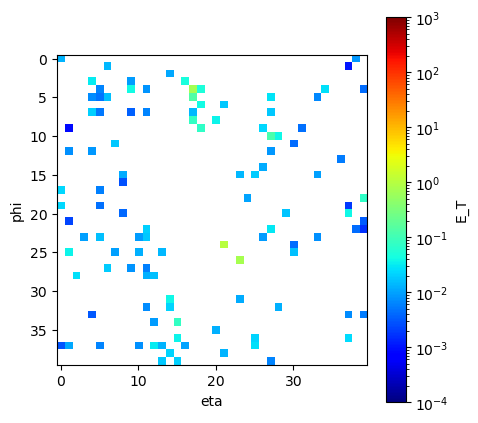

In [34]:
#masked_data = np.ma.masked_equal(np.mean(all_images_track_zprimeboson_lepton, axis = 0), 0.)
masked_data = sample_3_3_train_tower[0]
# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=0.0001, vmax=1000)

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("E_T")
plt.xlabel("eta")
plt.ylabel("phi")
#plt.savefig("Individual track picture - Zprime boson")
#plt.gca().invert_yaxis()
plt.show()

In [35]:
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import pickle

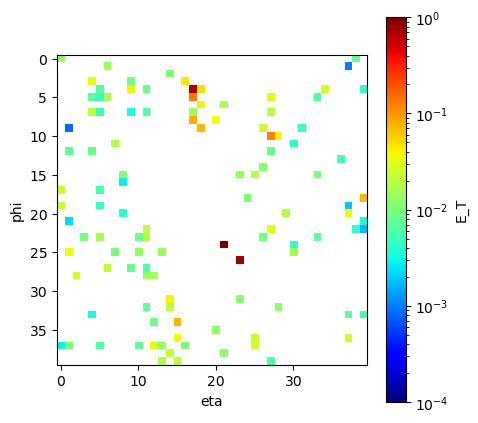

In [36]:
# Create a colormap based on 'jet'
jet = plt.cm.jet

# Create a custom colormap with white for masked values
colors = jet(np.linspace(0, 1, 256))
custom_cmap = mcolors.ListedColormap(colors)
# Use a logarithmic norm, avoiding zero values
norm = mcolors.LogNorm(vmin=0.0001, vmax=1)
masked_data = sample_3_3_train_tower[0]

# Plot using imshow with the custom colormap and logarithmic normalization
plt.figure(figsize = (5,5))
plt.imshow(masked_data, cmap=custom_cmap, norm=norm, interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label("E_T")
plt.xlabel("eta")
plt.ylabel("phi")
#plt.savefig("Individual tower picture - Zprime boson")
#plt.gca().invert_yaxis()
plt.show()

In [37]:
print(np.min(sample_3_3_train_tower[0]))

0.0


In [38]:
print(np.shape(sample_1_1_train_tower), np.shape(sample_1_2_train_tower), np.shape(sample_1_3_train_tower))


(696919, 40, 40) (3472, 40, 40) (12811, 40, 40)


In [39]:
print(np.shape(sample_2_1_train_tower), np.shape(sample_2_2_train_tower), np.shape(sample_2_3_train_tower))

(325063, 40, 40) (4789, 40, 40) (21039, 40, 40)


In [40]:
print(np.shape(sample_3_1_train_tower), np.shape(sample_3_2_train_tower), np.shape(sample_3_3_train_tower))

(157590, 40, 40) (2488, 40, 40) (22114, 40, 40)


In [41]:
print(np.shape(sample_1_3_train_tower)[0] + np.shape(sample_2_3_train_tower)[0] + np.shape(sample_3_3_train_tower)[0])

55964


In [19]:
rng = np.random.default_rng()
x_1_track = np.concatenate((sample_1_1_train_track, sample_1_2_train_track, sample_1_3_train_track))
x_1_tower = np.concatenate((sample_1_1_train_tower, sample_1_2_train_tower, sample_1_3_train_tower))
y_1 = np.tile(np.array([1., 0., 0.]), 
        np.shape(x_1_track)[0]).reshape(np.shape(x_1_track)[0],n_samples)
true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                                true_label_sample_1_3_train))
indices_1 = rng.permutation(np.shape(x_1_track)[0])

x_shuffle_1_track = x_1_track[indices_1]
x_shuffle_1_tower = x_1_tower[indices_1]

y_shuffle_1 = y_1[indices_1]
true_label_shuffle_1 = true_label_1[indices_1]

x_2_track = np.concatenate((sample_2_1_train_track, sample_2_2_train_track, sample_2_3_train_track))
x_2_tower = np.concatenate((sample_2_1_train_tower, sample_2_2_train_tower, sample_2_3_train_tower))
y_2 = np.tile(np.array([0., 1., 0.]), 
        np.shape(x_2_track)[0]).reshape(np.shape(x_2_track)[0],n_samples)
true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                                true_label_sample_2_3_train))
indices_2 = rng.permutation(np.shape(x_2_track)[0])

x_shuffle_2_track = x_2_track[indices_2]
x_shuffle_2_tower = x_2_tower[indices_2]

y_shuffle_2 = y_2[indices_2]
true_label_shuffle_2 = true_label_2[indices_2]

x_3_track = np.concatenate((sample_3_1_train_track, sample_3_2_train_track, sample_3_3_train_track))
x_3_tower = np.concatenate((sample_3_1_train_tower, sample_3_2_train_tower, sample_3_3_train_tower))
y_3 = np.tile(np.array([0., 0., 1.]), 
        np.shape(x_3_track)[0]).reshape(np.shape(x_3_track)[0],n_samples)
true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                                true_label_sample_3_3_train))
indices_3 = rng.permutation(np.shape(x_3_track)[0])

x_shuffle_3_track = x_3_track[indices_3]
x_shuffle_3_tower = x_3_tower[indices_3]

y_shuffle_3 = y_3[indices_3]
true_label_shuffle_3 = true_label_3[indices_3]

In [48]:
#Prepare samples to test for sculpting
pure_sample_sculpting_track = np.concatenate((sample_1_1_train_track, sample_2_1_train_track, sample_3_1_train_track))
pure_sample_sculpting_tower = np.concatenate((sample_1_1_train_tower, sample_2_1_train_tower, sample_3_1_train_tower))

y_sculpting_1 = np.tile(np.array([1., 0., 0.]), 
        np.shape(sample_1_1_train_track)[0]).reshape(np.shape(sample_1_1_train_track)[0],n_samples)
y_sculpting_2 = np.tile(np.array([0., 1., 0.]), 
        np.shape(sample_2_1_train_track)[0]).reshape(np.shape(sample_2_1_train_track)[0],n_samples)
y_sculpting_3 = np.tile(np.array([0., 0., 1.]), 
        np.shape(sample_3_1_train_track)[0]).reshape(np.shape(sample_3_1_train_track)[0],n_samples)
y_sculpting = np.concatenate((y_sculpting_1, y_sculpting_2, y_sculpting_3))
rng_sculpting = np.random.default_rng()
indices_sculpting = rng_sculpting.permutation(np.shape(pure_sample_sculpting_track)[0])

train_sculpting_track = pure_sample_sculpting_track[indices_sculpting]
train_sculpting_tower = pure_sample_sculpting_tower[indices_sculpting]
y_shuffle_sculpting = y_sculpting[indices_sculpting]s

In [49]:
print(np.shape(train_sculpting_tower))

(1179572, 40, 40)


In [50]:
x_track = np.concatenate((x_shuffle_1_track, x_shuffle_2_track, x_shuffle_3_track))
x_tower = np.concatenate((x_shuffle_1_tower, x_shuffle_2_tower, x_shuffle_3_tower))
y = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
true_label = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

indices_shuffle = rng.permutation(np.shape(y)[0])

x_track = x_track[indices_shuffle]
x_tower = x_tower[indices_shuffle]
y = y[indices_shuffle]

true_label = true_label[indices_shuffle]

from sklearn.model_selection import train_test_split
x_track_train, x_track_test, x_tower_train, x_tower_test, y_train, y_test, true_label_train, true_label_test = train_test_split(
    x_track, x_tower, y, true_label, test_size=0.2, random_state=42)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis = 1)),
    y=np.argmax(y_train, axis = 1)
)
class_weights_dict = dict(enumerate(class_weights))


In [51]:

model = build_model(x_track.shape[1])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
'''
history = model.fit([x_track_train, x_tower_train], y_train, validation_split = 0.2, epochs=200, batch_size=1024, class_weight=class_weights_dict,
                     verbose=1, 
                    callbacks=[early_stopping,
                                  ])
'''
history = model.fit([train_sculpting_track, train_sculpting_tower], y_shuffle_sculpting, validation_split = 0.2, epochs=200, batch_size=1024, verbose=1, 
                   callbacks=[
                                early_stopping,
                                   ])

model.save(f'multiclass_sculpting_cwola.keras')




Epoch 1/200
922/922 [==============================] - 53s 57ms/step - loss: 0.5179 - accuracy: 0.7899 - val_loss: 0.4333 - val_accuracy: 0.8332
Epoch 2/200
922/922 [==============================] - 52s 56ms/step - loss: 0.3983 - accuracy: 0.8433 - val_loss: 0.3823 - val_accuracy: 0.8480
Epoch 3/200
922/922 [==============================] - 50s 54ms/step - loss: 0.3638 - accuracy: 0.8551 - val_loss: 0.3753 - val_accuracy: 0.8497
Epoch 4/200
922/922 [==============================] - 50s 55ms/step - loss: 0.3433 - accuracy: 0.8620 - val_loss: 0.3530 - val_accuracy: 0.8579
Epoch 5/200
922/922 [==============================] - 50s 54ms/step - loss: 0.3287 - accuracy: 0.8673 - val_loss: 0.3389 - val_accuracy: 0.8623
Epoch 6/200
922/922 [==============================] - 51s 55ms/step - loss: 0.3183 - accuracy: 0.8712 - val_loss: 0.3346 - val_accuracy: 0.8641
Epoch 7/200
922/922 [==============================] - 51s 55ms/step - loss: 0.3094 - accuracy: 0.8748 - val_loss: 0.3334 - val_ac

In [43]:
model = keras.models.load_model('multiclass_sculpting_cwola.keras')


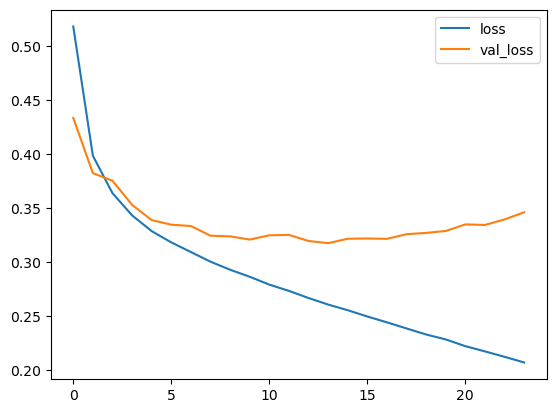

In [52]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

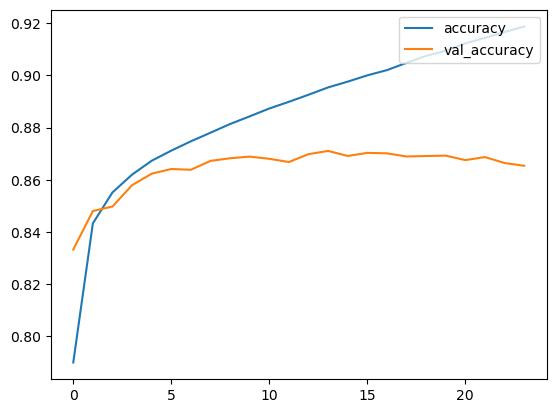

In [53]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [69]:
test_sample_sculpting_track = np.concatenate((sample_1_1_train_track, sample_2_1_train_track, sample_3_1_train_track))
test_sample_sculpting_tower = np.concatenate((sample_1_1_train_tower, sample_2_1_train_tower, sample_3_1_train_tower))

y_test_sculpting_1 = np.tile(np.array([1., 0., 0.]), 
        np.shape(sample_1_1_train_track)[0]).reshape(np.shape(sample_1_1_train_track)[0],n_samples)
y_test_sculpting_2 = np.tile(np.array([0., 1., 0.]), 
        np.shape(sample_2_1_train_track)[0]).reshape(np.shape(sample_2_1_train_track)[0],n_samples)
y_test_sculpting_3 = np.tile(np.array([0., 0., 1.]), 
        np.shape(sample_3_1_train_track)[0]).reshape(np.shape(sample_3_1_train_track)[0],n_samples)
y_test_sculpting = np.concatenate((y_test_sculpting_1, y_test_sculpting_2, y_test_sculpting_3))
rng_test_sculpting = np.random.default_rng()
indices_test_sculpting = rng_test_sculpting.permutation(np.shape(test_sample_sculpting_track)[0])

test_sculpting_track = test_sample_sculpting_track[indices_test_sculpting]
test_sculpting_tower = test_sample_sculpting_tower[indices_test_sculpting]
y_test_shuffle_sculpting = y_test_sculpting[indices_test_sculpting]

In [70]:
print(test_sample_sculpting_track.shape)

(1179572, 40, 40)


In [ ]:
model.evaluate([test_sculpting_track, test_sculpting_tower], y_test_shuffle_sculpting)

35750/36862 [============================>.] - ETA: 5s - loss: 0.2263 - accuracy: 0.9126

In [65]:
model.evaluate([sample_3_3_train_track, sample_3_3_train_tower], true_label_sample_3_3_train)


692/692 [==============================] - 3s 5ms/step - loss: 1.2265 - accuracy: 0.6452


[1.2264866828918457, 0.6452473402023315]

In [63]:
print(model.predict([test_sculpting_track, test_sculpting_tower]))

[[1.5833306e-01 8.4100586e-01 6.6108198e-04]
 [1.7334240e-03 2.5348380e-01 7.4478281e-01]
 [1.2909875e-02 9.6708262e-01 2.0007476e-02]
 ...
 [9.1469508e-01 6.8851583e-02 1.6453406e-02]
 [8.6498445e-01 1.3488680e-01 1.2882416e-04]
 [6.5447813e-01 2.8179774e-01 6.3724160e-02]]


In [24]:
predict = model.predict([x_track_test, x_tower_test])

predict_0 = predict[np.argmax(predict, axis = 1) == 0]
predict_1 = predict[np.argmax(predict, axis = 1) == 1]
predict_2 = predict[np.argmax(predict, axis = 1) == 2]
print(np.shape(predict_0), np.shape(predict_1), np.shape(predict_2))
predict_0_true = predict[(np.argmax(predict, axis = 1) == 0) & (np.argmax(true_label_test, axis = 1) == 0)]
predict_1_true = predict[(np.argmax(predict, axis = 1) == 1) & (np.argmax(true_label_test, axis = 1) == 1)]
predict_2_true = predict[(np.argmax(predict, axis = 1) == 2) & (np.argmax(true_label_test, axis = 1) == 2)]
print(np.shape(predict_0_true), np.shape(predict_1_true), np.shape(predict_2_true))




2025-09-12 01:04:46.803658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


(132405, 3) (76793, 3) (40059, 3)
(130058, 3) (922, 3) (5093, 3)


In [25]:
predict_true_0 = predict[(np.argmax(true_label_test, axis = 1) == 0)]
predict_true_1 = predict[(np.argmax(true_label_test, axis = 1) == 1)]
predict_true_2 = predict[(np.argmax(true_label_test, axis = 1) == 2)]
print(np.shape(predict_true_0), np.shape(predict_true_1), np.shape(predict_true_2))

(235939, 3) (2104, 3) (11214, 3)


In [26]:
print(model.evaluate([x_track_test, x_tower_test], y_test))

7790/7790 [==============================] - 35s 4ms/step - loss: 0.2979 - accuracy: 0.8846
[0.2978536784648895, 0.8846170902252197]


In [27]:
print(model.evaluate([x_track_test, x_tower_test], true_label_test))

7790/7790 [==============================] - 41s 5ms/step - loss: 2.4347 - accuracy: 0.5459
[2.4347074031829834, 0.5459144711494446]


In [33]:
num_classes = 3
x_train_post_model = model.predict([x_track_train[0:1000], x_tower_train[0:1000]])
spec_model = SpectralClustering(n_clusters=num_classes, assign_labels = 'discretize')
spec_results = spec_model.fit_predict(x_train_post_model)
model_clustering =  build_model_clustering(x_train_post_model.shape[1])
one_hot_spec_results = np.eye(num_classes)[spec_results]
history_2 = model_clustering.fit(x_train_post_model, one_hot_spec_results, epochs = 10)

x_predict_pre_kmeans = model.predict([x_track_test[0:10000], x_tower_test[0:10000]])
x_predict_post_spec = spec_model.fit_predict(x_predict_pre_kmeans)
predicted_labels = np.argmax(true_label_test[0:10000], axis = 1)

conf_matrix_spec = confusion_matrix(predicted_labels, x_predict_post_spec, labels = [0, 1, 2])
print(conf_matrix_spec)
# Step 2: Use Hungarian algorithm for optimal label assignment
row_ind_spec, col_ind_spec = linear_sum_assignment(-conf_matrix_spec)  # Maximize matches
# Step 3: Map predicted labels to desired labels
label_mapping_spec = {row_spec: col_spec for col_spec, row_spec in zip(row_ind_spec, col_ind_spec)}
final_labels_spec = np.array([label_mapping_spec[label_spec] for label_spec in x_predict_post_spec])

accuracy_spec = np.mean(final_labels_spec == np.argmax(true_label_test[0:10000], axis = 1))
print(f"Spectral Clustering accuracy on pure data, {accuracy_spec*100:.2f}%")

x_predict_post_ml = np.argmax(model_clustering.predict(x_predict_pre_kmeans), axis = 1)
#Rematching of labels
conf_matrix_ml = confusion_matrix(predicted_labels, x_predict_post_ml, labels = [0, 1, 2])
# Step 2: Use Hungarian algorithm for optimal label assignment
row_ind_ml, col_ind_ml = linear_sum_assignment(-conf_matrix_ml)  # Maximize matches

# Step 3: Map predicted labels to desired labels
label_mapping_ml = {row_ml: col_ml for col_ml, row_ml in zip(row_ind_ml, col_ind_ml)}

# Apply mapping to reorder labels
final_labels_ml = np.array([label_mapping_ml[label_ml] for label_ml in x_predict_post_ml])
accuracy_ml = np.mean(final_labels_ml == np.argmax(true_label_test[0:10000], axis = 1))
print(f"ML accuracy on pure data, {accuracy_ml*100:.2f}%")


Epoch 1/10
32/32 [==============================] - 0s 3ms/step - loss: 0.4755 - accuracy: 0.9300
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0340 - accuracy: 0.9920
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0270 - accuracy: 0.9930
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0183 - accuracy: 0.9950
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0176 - accuracy: 0.9970
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.9910
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0124 - accuracy: 0.9980
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 0.9910
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0127 - accuracy: 0.9960
Epoch 10/10
32/32 [==============================] - 0s 3ms/step - loss: 0.0353 - accuracy: 0.9860
[[2880 1398 5170]
 

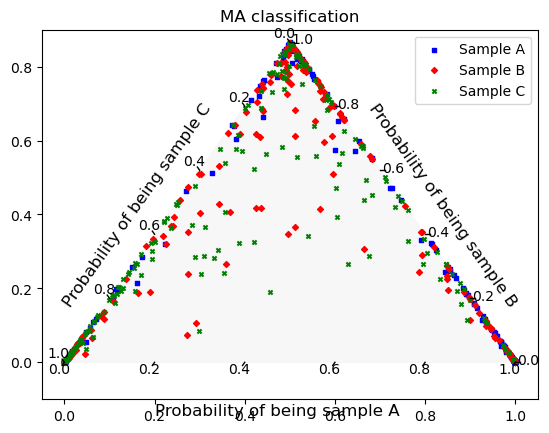

In [34]:
import ternary
scale = 1.0
fontsize = 12
offset = 0.1
figure, tax = ternary.figure(scale=scale)

tax.set_title("MA classification", fontsize=fontsize)
tax.left_axis_label("Probability of being sample C", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being sample B", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being sample A", fontsize=fontsize, offset=offset)
tax.scatter(predict_true_0[0:200], color = 'blue', marker = 's', s = 9, label="Sample A")
tax.scatter(predict_true_1[0:200], color = 'red', marker = 'D', s = 9, label="Sample B")
tax.scatter(predict_true_2[0:200], color = 'green', marker = 'x', s = 9, label="Sample C")
plt.legend()
# Set ticks
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")


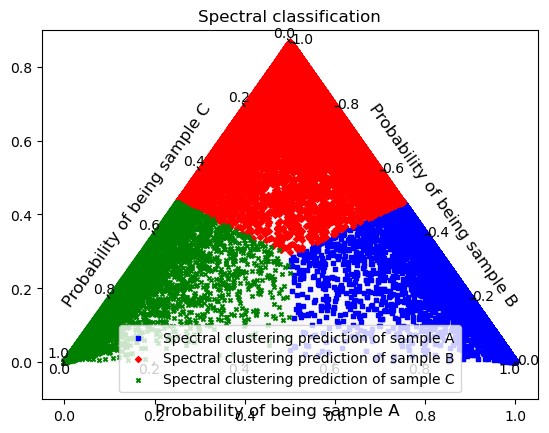

In [35]:
import ternary
scale = 1.0
fontsize = 12
offset = 0.1
figure, tax = ternary.figure(scale=scale)

tax.set_title("Spectral classification", fontsize=fontsize)
tax.left_axis_label("Probability of being sample C", fontsize=fontsize, offset=offset)
tax.right_axis_label("Probability of being sample B", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Probability of being sample A", fontsize=fontsize, offset=offset)
tax.scatter(predict_0, color = 'blue', marker = 's', s = 9, label="Spectral clustering prediction of sample A")
tax.scatter(predict_1, color = 'red', marker = 'D', s = 9, label="Spectral clustering prediction of sample B")
tax.scatter(predict_2, color = 'green', marker = 'x', s = 9, label="Spectral clustering prediction of sample C")
# Set ticks
tax.legend()
tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")


In [ ]:
#Evaluate on the true labels
loss, accuracy = model.evaluate([x_track_test, x_tower_test], true_label_test)

In [ ]:
#Evaluate on the training labels
loss, accuracy = model.evaluate([x_track_test, x_tower_test], y_test)
print(accuracy)